In [2]:
import pandas as pd
import shap
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from core import bw_color_palette
import seaborn.objects as so
from seaborn import axes_style
import gpplot

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [ ]:
%%time
ft_X = pd.read_parquet('../data/interim/test_X_fe.pq')
X = pd.read_parquet('../data/interim/test_X.pq')
y = pd.read_parquet('../data/interim/test_y_indexed.pq')
beaker = load('../models/beaker_v3.pkl')
seq_neighbors = pd.read_parquet('../data/interim/model_protein_neighbors_seq_ids.pq').reset_index()
df_homolog_df = pd.read_parquet('../data/interim/defense_finder_homologs_profile_names.pq')

CPU times: user 46.5 s, sys: 40.5 s, total: 1min 27s
Wall time: 1min 10s


In [ ]:
%%time
seq_names = pd.read_parquet('../data/interim/seq_id_names.pq')

CPU times: user 30.3 s, sys: 9.78 s, total: 40.1 s
Wall time: 43 s


In [ ]:
%%time
cluster_df = (pd.read_table('../data/interim/refseqs_clusters_mode1.tsv', 
                        names=['cluster_id', 'seq_id'])
              .set_index('seq_id'))

CPU times: user 1min 19s, sys: 8.21 s, total: 1min 27s
Wall time: 1min 28s


In [ ]:
cat_X_y = pd.concat([X, y], axis=1)

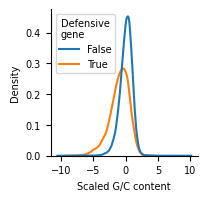

In [ ]:
plt.subplots(figsize=(1.9,1.9))
ax = sns.kdeplot(data=cat_X_y, x='scaled_gc_frac_0', hue='defense', 
            common_norm=False)
sns.despine()
plt.xlabel('Scaled G/C content')
sns.move_legend(ax, 'upper left', title='Defensive\ngene')
plt.savefig('../figures/scaled_gc.svg', dpi=300, bbox_inches='tight')

In [ ]:
cat_X_y.groupby('defense').agg({'scaled_gc_frac_0': ['mean', 'std', 'count']})

scaled_gc_frac_0                  
                    mean       std   count
defense                                   
False           0.065872  0.970969  166243
True           -0.955026  1.506259   10128

## Skip the next four cells if shap values have already been calculated

In [4]:
X.shape

(176371, 3319)

In [5]:
explainer = shap.TreeExplainer(beaker)

In [6]:
%%time
test_shap_values = explainer(X)

CPU times: user 4d 14h 52min 47s, sys: 15.9 s, total: 4d 14h 53min 3s
Wall time: 2h 19min 19s


In [7]:
shap_value_df = pd.DataFrame(test_shap_values.values[:, :, 1])

In [8]:
shap_value_df.to_parquet('../data/interim/test_shap_values.pq')

## End skip

In [ ]:
shap_value_df = pd.read_parquet('../data/interim/test_shap_values.pq')

In [ ]:
%%time
long_test_X = X.melt(ignore_index=False)
long_test_X = (long_test_X.reset_index()
               .rename(columns={'index':'seq_id'}))

CPU times: user 50.5 s, sys: 30.8 s, total: 1min 21s
Wall time: 1min 21s


In [ ]:
long_test_shap_values = (shap_value_df.melt(value_name='shap_value', var_name='column')
                          .drop(columns=['column']))

In [ ]:
del shap_value_df

In [ ]:
cat_test_X_shap = pd.concat([long_test_X, long_test_shap_values], 
                             axis=1)

In [ ]:
all_gene_component_df = pd.read_csv('../data/interim/defense_finder_gene_split_df.csv')

In [ ]:
test_annotations = pd.read_parquet('../data/interim/test_seq_names_processes.pq')


In [ ]:
(y.index == X.index).all()

True

In [ ]:
y_hat = beaker.predict_proba(X)[:, 1]

In [ ]:
cutoff = 0.5
true_positives = (y['defense'] & (y_hat > cutoff))
true_positives.sum()

8653

In [ ]:
tp_ids = y.index[true_positives].to_list()

In [ ]:
tp_cat_shap = cat_test_X_shap[cat_test_X_shap['seq_id'].isin(tp_ids)].copy()

In [ ]:
test_gene_component_df = all_gene_component_df[all_gene_component_df['split'] == 'test'].reset_index(drop=True)


In [ ]:
merged_pos_annot = (test_gene_component_df.rename(columns={'name': 'gene_name'})
                    .merge(test_annotations, how='inner', on='gene_name'))

In [ ]:
merged_tp_cat_shap = (tp_cat_shap.merge(merged_pos_annot, how='inner', on='seq_id'))

In [ ]:
tp_component_shap_summary = (merged_tp_cat_shap.groupby(['component', 'variable'])
                             .agg(n = ('seq_id', 'nunique'), 
                                  mean_shap = ('shap_value', 'mean'))
                             .reset_index())

In [ ]:
tp_component_shap_summary['component'].nunique()

36

In [ ]:
tp_shap_summary = (tp_component_shap_summary.groupby('variable')
                   .agg(mean_shap=('mean_shap', 'mean'))
                   .reset_index()
                   .sort_values('mean_shap', ascending=False))

In [ ]:
tp_shap_summary['abs_shap'] = tp_shap_summary['mean_shap'].abs()

In [ ]:
tp_shap_summary.head(50)

,variable,mean_shap,abs_shap
851,ft252_0,1.878567,1.878567
846,ft251_0,1.263662,1.263662
696,ft224_0,1.180487,1.180487
2711,ft588_0,1.123987,1.123987
3316,scaled_gc_frac_0,0.983296,0.983296
2526,ft554_0,0.837895,0.837895
3096,ft7_0,0.753421,0.753421
876,ft257_0,0.683818,0.683818
2256,ft505_0,0.537600,0.537600
2036,ft466_0,0.473344,0.473344


In [ ]:
del long_test_X, long_test_shap_values

In [ ]:
def assign_feature(name):
    if 'scaled' in name:
        return 'nucleotide'
    if 'ft' in name:
        return 'ESM2'
    if 'len' in name:
        return 'length'
    if 'dist' in name:
        return 'dist'
    if 'co_directional' in name:
        return 'strand'

In [ ]:
tp_shap_summary['position'] = [x[-1] for x in tp_shap_summary['variable'].str.split('_')]
tp_shap_summary['position'] = [min(abs(int(x[0])), abs(int(x[1]))) if len(x) == 2 else int(x[0]) for x in tp_shap_summary['position'].str.split(':')]
tp_shap_summary['category'] = tp_shap_summary['variable'].apply(assign_feature)

In [ ]:
tp_category_summary = (tp_shap_summary.groupby(['position', 'category'])
                       .agg(sum_shap=('mean_shap', 'sum'))
                       .reset_index())

In [ ]:
tp_category_summary['category'] = pd.Categorical(tp_category_summary['category'], 
                                                    categories=['ESM2', 'nucleotide', 
                                                                 'length', 'dist', 'strand'])

In [ ]:
tp_category_summary['position'] = pd.Categorical(tp_category_summary['position'])

In [ ]:
tp_category_summary['absolute_position'] = tp_category_summary['position'].astype(int).abs()

In [ ]:
tp_category_summary.sort_values('sum_shap', ascending=False)

,position,category,sum_shap,absolute_position
8,0,ESM2,23.687877,0
4,-1,ESM2,2.283849,1
13,1,ESM2,2.215921,1
11,0,nucleotide,1.817888,0
18,2,ESM2,0.880294,2
0,-2,ESM2,0.753793,2
9,0,dist,0.328787,0
10,0,length,0.187522,0
16,1,nucleotide,0.042126,1
6,-1,nucleotide,0.029105,1


In [ ]:
tp_category_summary.groupby(['absolute_position', 'category']).agg({'sum_shap': ['mean', 'count']})

sum_shap      
                                   mean count
absolute_position category                   
0                 ESM2        23.687877     1
                  nucleotide   1.817888     1
                  length       0.187522     1
                  dist         0.328787     1
                  strand       0.000000     1
1                 ESM2         2.249885     2
                  nucleotide   0.035615     2
                  length       0.021683     2
                  dist         0.006763     1
                  strand       0.022330     2
2                 ESM2         0.817043     2
                  nucleotide   0.005948     2
                  length       0.004287     2
                  dist              NaN     0
                  strand       0.000748     2

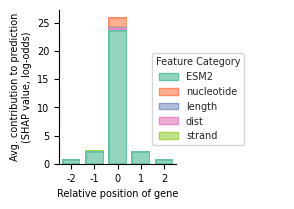

In [ ]:
fig, ax = plt.subplots(figsize=(1.5,2))
(
    so.Plot(tp_category_summary.rename(columns={'category': 'Feature Category'}), 
            x='position', y='sum_shap', color='Feature Category')
    .add(so.Bar(), so.Stack())
    .on(ax)
    .theme({**axes_style("white"), 'legend.fontsize': 7, 'legend.title_fontsize': 7})
    .label(y='Avg. contribution to prediction\n(SHAP value, log-odds)', 
           x='Relative position of gene')
    .scale(color='Set2')
    .plot()
)
sns.despine(fig)
plt.savefig('../figures/category_feature_importance_test_tp.svg', dpi=300, bbox_inches='tight')

### Plotting G/C content

In [ ]:
gc_test_X_shap = cat_test_X_shap[cat_test_X_shap['variable'] == 'scaled_gc_frac_0']

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

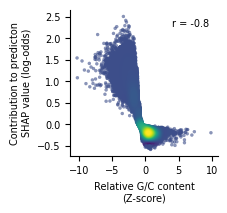

In [ ]:
plt.subplots(figsize=(1.9,1.9))
gpplot.point_densityplot(data=gc_test_X_shap, x='value', y='shap_value', s=5)
gpplot.add_correlation(data=gc_test_X_shap, x='value', y='shap_value', loc='upper right')
plt.ylabel('Contribution to predicton\nSHAP value (log-odds)')
plt.xlabel('Relative G/C content\n(Z-score)')
sns.despine()
plt.savefig('../figures/gc_content_shap.svg', dpi=300, bbox_inches='tight', )

In [ ]:
cat_test_X_shap

,seq_id,variable,value,shap_value
0,0000131212b640442569537f5a84e127f7b807991f612d...,ft1_-2,0.017506,0.000012
1,76091e4b264b0db4ab9012f0dd30ea94d649f6bfac0d7a...,ft1_-2,0.047707,0.000141
2,8cb035bc5a3d2c19290cff24b7ed4fc67a0e17baf17577...,ft1_-2,0.031352,-0.000018
3,93c941d9b3e66212ecbe3a8d67356eaab319bf6237cc22...,ft1_-2,-0.028908,0.000193
4,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,ft1_-2,-0.064863,-0.000337
...,...,...,...,...
585375344,3b568c40e94e4ce1938536a639ff6b7b08a7726237ff50...,dist_1:2,-3.000000,-0.014083
585375345,bb26bb85d04cad15da2cecfa25aeedd26d7c7542b37eff...,dist_1:2,116.000000,0.001281
585375346,c665e87dcc1189f8c0c8b49b7a75dd63d9573cafad31fb...,dist_1:2,-13.000000,-0.004510
585375347,8c060d0fa8b42b4d116691d670003a2f69b2bbf260aa5e...,dist_1:2,-7.000000,0.011481


## Get importance of neighbors


### Importance of defense neighbors, integrases and transposases

In [ ]:
feature_mapping = cat_test_X_shap[['variable']].drop_duplicates()
feature_mapping['position'] = [x[-1] for x in feature_mapping['variable'].str.split('_')]
feature_mapping['position'] = [min(abs(int(x[0])), abs(int(x[1]))) if len(x) == 2 else int(x[0]) for x in feature_mapping['position'].str.split(':')]
feature_mapping['category'] = feature_mapping['variable'].apply(assign_feature)

In [ ]:
per_seq_importance = (cat_test_X_shap.merge(feature_mapping, how='inner', on='variable')
                      .groupby(['seq_id', 'position'])
                      .agg(sum_shap=('shap_value', 'sum'))
                      .reset_index()
                      .rename(columns={'seq_id': 'center_seq_id', 
                                       'position': 'relative_position'})
                      .merge(seq_neighbors, how='inner', 
                             on=['center_seq_id', 'relative_position']))
per_seq_importance['absolute_position'] = per_seq_importance['relative_position'].abs()

In [ ]:
unique_names = seq_names['name'].drop_duplicates()

#### Defense Neighbor

In [ ]:
per_seq_importance['defense_homolog'] = per_seq_importance['seq_id'].isin(df_homolog_df['seq_id'])
(per_seq_importance.groupby(['absolute_position', 'defense_homolog'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n   avg_shap
absolute_position defense_homolog                   
0                 False            160439  -1.783720
                  True              15932  15.655721
1                 False            320628  -0.168090
                  True              23703   2.414677
2                 False            320003  -0.044167
                  True              20384   1.211125

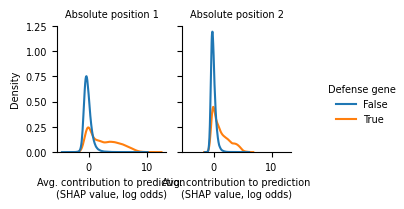

In [ ]:
g= sns.displot(data=per_seq_importance[per_seq_importance['absolute_position'] != 0], 
               kind='kde', x='sum_shap', col='absolute_position', hue='defense_homolog', 
               common_norm=False, height=2, aspect=0.75)
g.set_axis_labels(x_var='Avg. contribution to prediction\n(SHAP value, log odds)')
g.set_titles(col_template="Absolute position {col_name}")
g._legend.set_title('Defense gene')
plt.savefig('../figures/defense_homlog_pred_contrib.svg', dpi=300, bbox_inches='tight')

#### Integrase

In [ ]:
integrase_regex = 'integrase'

In [ ]:
integrase_names = unique_names[unique_names.str.contains(integrase_regex)]
integrase_seq_ids = seq_names.loc[seq_names['name'].isin(integrase_names), 'seq_id']

In [ ]:
per_seq_importance['integrase'] = per_seq_importance['seq_id'].isin(integrase_seq_ids)
(per_seq_importance.groupby(['absolute_position', 'integrase'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n  avg_shap
absolute_position integrase                  
0                 False      172548 -0.121855
                  True         3823 -4.113392
1                 False      343058  0.008078
                  True         1273  0.447264
2                 False      339337  0.029310
                  True         1050  0.579058

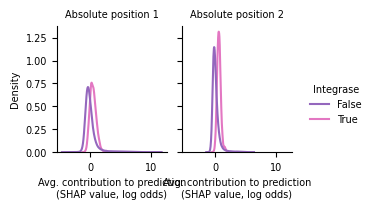

In [ ]:
g= sns.displot(data=per_seq_importance[per_seq_importance['absolute_position'] != 0], 
               kind='kde', x='sum_shap', col='absolute_position', hue='integrase', 
               common_norm=False, height=2, aspect=0.75, 
               palette=[sns.color_palette("tab10")[4], sns.color_palette("tab10")[6]])
g.set_axis_labels(x_var='Avg. contribution to prediction\n(SHAP value, log odds)')
g.set_titles(col_template="Absolute position {col_name}")
g._legend.set_title('Integrase')
plt.savefig('../figures/integrase_neighbor_contrib.svg', dpi=300, bbox_inches='tight')

#### Transposase

In [ ]:
transposase_regex = 'transposase'

In [ ]:
transposase_names = unique_names[unique_names.str.contains(transposase_regex)]
transposase_seq_ids = seq_names.loc[seq_names['name'].isin(transposase_names), 'seq_id']

In [ ]:
per_seq_importance['transposase'] = per_seq_importance['seq_id'].isin(transposase_seq_ids)
(per_seq_importance.groupby(['absolute_position', 'transposase'])
 .agg(n=('seq_id', 'count'), 
      avg_shap=('sum_shap', 'mean')))

n  avg_shap
absolute_position transposase                  
0                 False        173258 -0.161593
                  True           3113 -2.812054
1                 False        341597  0.003998
                  True           2734  0.722360
2                 False        338043  0.027096
                  True           2344  0.594758

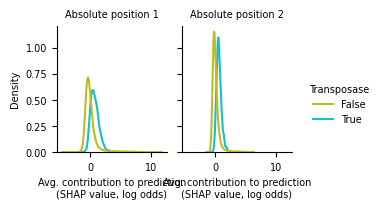

In [ ]:
g= sns.displot(data=per_seq_importance[per_seq_importance['absolute_position'] != 0], 
               kind='kde', x='sum_shap', col='absolute_position', hue='transposase', 
               common_norm=False, height=2, aspect=0.75, 
               palette=[sns.color_palette("tab10")[-2], sns.color_palette("tab10")[-1]])
g.set_axis_labels(x_var='Avg. contribution to prediction\n(SHAP value, log odds)')
g.set_titles(col_template="Absolute position {col_name}")
g._legend.set_title('Transposase')
plt.savefig('../figures/transposase_neighbor_contrib.svg', dpi=300, bbox_inches='tight')

In [ ]:
def assign_neighbor_type(row):
    if row['defense_homolog']:
        return 'defensive'
    elif row['integrase']:
        return 'integrase'
    elif row['transposase']:
        return 'transposase'
    else:
        return 'other'

In [ ]:
per_seq_importance['neighbor_type'] = per_seq_importance.apply(assign_neighbor_type, axis=1)


In [ ]:
neighbor_type_count = (per_seq_importance.groupby(['neighbor_type', 'absolute_position'])
                       .agg(neighbor_type_n=('protein_context_id', 'count'))
                       .reset_index())
neighbor_type_count['display_neighbor_type'] = (neighbor_type_count['neighbor_type'] + 
                                               ' (n=' + 
                                               neighbor_type_count['neighbor_type_n'].astype(str) + 
                                               ')')



In [ ]:
per_seq_importance = (per_seq_importance.merge(neighbor_type_count, how='inner', 
                                               on=['neighbor_type', 'absolute_position']))



In [ ]:
per_seq_importance['neighbor_type'] = pd.Categorical(per_seq_importance['neighbor_type'],
                                                     categories=['other', 'integrase', 'transposase', 'defensive'])

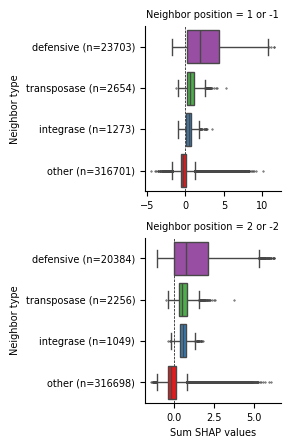

In [ ]:
g = sns.FacetGrid(data=(per_seq_importance
                        .query('absolute_position != 0')
                        .sort_values('neighbor_type', ascending=False)), 
                  row='absolute_position', sharey=False, sharex=False, height=2.25, 
                  aspect=1.3)
g.map_dataframe(sns.boxplot, y='display_neighbor_type', x='sum_shap', saturation=1, 
                hue='neighbor_type', palette='Set1', fliersize=0.5)
g.map(plt.axvline, x=0, linestyle='dashed', color='black', zorder=0, linewidth=0.5)
g.set_axis_labels(x_var='Sum SHAP values', y_var='Neighbor type')
g.set_titles(row_template='Neighbor position = {row_name} or -{row_name}')
plt.savefig('../figures/sum_shap_neighbor_type_box.svg', dpi=300, bbox_inches='tight')

In [ ]:
seq_names.shape

(66531289, 2)

In [ ]:
relevant_seq_names = seq_names[seq_names['seq_id'].isin(per_seq_importance['seq_id'])]

In [ ]:
merged_per_seq_importance = (per_seq_importance.merge(relevant_seq_names, how='inner', 
                                                      on='seq_id'))

In [ ]:
merged_per_seq_importance

,center_seq_id,relative_position,sum_shap,protein_accession,seq_id,protein_context_id,absolute_position,defense_homolog,integrase,transposase,neighbor_type,neighbor_type_n,display_neighbor_type,name
0,0000131212b640442569537f5a84e127f7b807991f612d...,-2,0.000147,WP_059055864.1,b008953871d7e786688f4bb8f9012d3f55f7e921b3d26e...,WP_059055864.1|NZ_LN831302.1|475799|+,2,False,False,False,other,316698,other (n=316698),hypothetical protein
1,0000131212b640442569537f5a84e127f7b807991f612d...,2,-0.114870,WP_059055860.1,f4a3b2acb86c1167700a5f451cbcba2dcdcdd04560f635...,WP_059055860.1|NZ_LN831302.1|472420|+,2,False,False,False,other,316698,other (n=316698),hypothetical protein
2,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,-2,0.612436,WP_059107348.1,4ca8fb996259c7d283150ce2d26e9507e72324af076caf...,WP_059107348.1|NZ_CP065712.1|371096|+,2,False,False,False,other,316698,other (n=316698),NYN domain-containing protein
3,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,2,-0.132599,WP_059107351.1,c8e4ea6d69c608b1792524e2d48f4668b3ea160e22f1d6...,WP_059107351.1|NZ_CP065712.1|372813|+,2,False,False,False,other,316698,other (n=316698),preprotein translocase subunit SecE
4,0000c3bf8c8e9cea36a2505104f89fd54c39b9e247e752...,-2,-0.165826,WP_161880672.1,84526e196035e09b1cbf5fe375f83336cfcf012c061bf3...,WP_161880672.1|NZ_WXZL01000002.1|115097|-,2,False,False,False,other,316698,other (n=316698),SDR family oxidoreductase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861084,ff5859c4610a1fde4aa57d616a53136e704a6d0afb021c...,-2,0.621494,WP_033435557.1,038bad1e5ccc16301467adcfeba716e7172c3666079d48...,WP_033435557.1|NZ_CP034550.1|6368819|-,2,False,True,False,integrase,1049,integrase (n=1049),site-specific integrase
861085,ff661698769e37febfeac3cea552c9720d2cf330d14691...,-2,0.058877,WP_018404746.1,d8913b6fcb6acbf0d9e9db3b4782a5c44ea5c4bc6e1081...,WP_018404746.1|NZ_KB889905.1|20895|-,2,False,True,False,integrase,1049,integrase (n=1049),tyrosine-type recombinase/integrase
861086,ff7da187b4d9330a0b43fc98780b6029f988b68c2a14e7...,-2,0.419986,WP_217289108.1,b834e4a97d7e2b55df0949f307eb3c8040a592c5c7b858...,WP_217289108.1|NZ_CP078096.1|4747632|+,2,False,True,False,integrase,1049,integrase (n=1049),site-specific integrase
861087,fffbd35fdbfea0e967a95c277d708e455e6bd8b26738cf...,2,1.124586,WP_206255503.1,9228057ae687c53677af15af4403545735b4ced342286a...,WP_206255503.1|NZ_CP071060.1|1298033|+,2,False,True,False,integrase,1049,integrase (n=1049),integrase domain-containing protein


In [82]:
name_importance = (merged_per_seq_importance.groupby(['name', 'absolute_position', 'neighbor_type'], observed=True)
                   .agg(mean_sum_shap=('sum_shap', 'mean'), 
                        sum_shap=('sum_shap', 'sum'),
                        std_shap=('sum_shap', 'std'), 
                        number=('center_seq_id', 'count'))
                   .reset_index())

In [84]:
name_importance[name_importance['absolute_position'] != 0].sort_values('sum_shap', ascending=False).head(50)
                                                                       

,name,absolute_position,neighbor_type,mean_sum_shap,sum_shap,std_shap,number
23023,hypothetical protein,1,other,0.257765,13398.619593,0.835791,51980
23025,hypothetical protein,2,other,0.245565,13381.094578,0.489846,54491
23024,hypothetical protein,1,defensive,3.658397,11710.529839,2.243789,3201
31338,type III-B CRISPR-associated protein Cas10/Cmr2,1,defensive,6.450514,4824.984844,1.229506,748
23026,hypothetical protein,2,defensive,2.040148,4427.122063,1.264978,2170
12516,RAMP superfamily CRISPR-associated protein,1,defensive,6.129977,3181.458082,1.182566,519
1222,AAA family ATPase,1,defensive,3.616013,2961.515015,1.764182,819
6202,DUF4194 domain-containing protein,1,defensive,4.320929,2480.213230,1.018333,574
31320,type III-B CRISPR module RAMP protein Cmr4,2,defensive,3.886441,2421.252568,0.717912,623
31319,type III-B CRISPR module RAMP protein Cmr4,1,defensive,5.836784,2223.814876,0.953161,381


In [85]:
(name_importance[(name_importance['absolute_position'] != 0) & 
                 (name_importance['neighbor_type'] != 'defensive')]
 .sort_values('sum_shap', ascending=False).head(50))


,name,absolute_position,neighbor_type,mean_sum_shap,sum_shap,std_shap,number
23023,hypothetical protein,1,other,0.257765,13398.619593,0.835791,51980
23025,hypothetical protein,2,other,0.245565,13381.094578,0.489846,54491
12515,RAMP superfamily CRISPR-associated protein,1,other,5.820255,1687.874002,1.226947,290
12517,RAMP superfamily CRISPR-associated protein,2,other,3.802344,1167.319523,0.724009,307
30620,transposase,1,transposase,0.639960,524.767118,0.715924,820
30622,transposase,2,transposase,0.604705,408.175841,0.479774,675
28848,sigma-70 family RNA polymerase sigma factor,2,other,0.412686,287.642032,0.329767,697
1221,AAA family ATPase,1,other,0.363072,269.762740,0.951189,743
11561,NYN domain-containing protein,1,other,1.670662,265.635231,0.567804,159
22542,helix-turn-helix domain-containing protein,2,other,0.164809,262.540062,0.327108,1593


In [87]:
neighbor_name_importance = name_importance[name_importance['absolute_position'] != 0]

In [88]:
neighbor_name_importance.to_csv('../data/processed/gene_name_SHAP_importance.csv', index=False)

In [72]:
merged_per_seq_importance.to_csv('../data/processed/gene_SHAP_importance.csv', index=False)

In [74]:
tp_shap_summary.to_csv('../data/processed/feature_SHAP_importance.csv', index=False)

### Importance of TP clusters

In [69]:
tp_per_seq_importance = (per_seq_importance[per_seq_importance['center_seq_id'].isin(tp_ids)]
                         .merge(merged_pos_annot.rename(columns={'seq_id': 'center_seq_id'})
                                [['center_seq_id', 'component_name']], 
                                how='inner', on='center_seq_id'))

Far and away the model is paying attention to adjacent defense homologs to make its prediction, supporting the defense island idea

In [72]:
(tp_per_seq_importance.groupby(['defense_homolog', 'absolute_position'])
 .agg({'sum_shap': 'sum'}))

sum_shap
defense_homolog absolute_position               
False           1                    7021.470654
                2                    4519.051723
True            0                  222081.872304
                1                   51529.786220
                2                   21053.324437

In [ ]:
tp_per_seq_importance_clusters = tp_per_seq_importance.merge(cluster_df, left_on='seq_id', right_index=True)

In [ ]:
cluster_sum_importance = (tp_per_seq_importance_clusters
                          .groupby(['cluster_id', 'absolute_position', 'component_name'])
                          .agg(avg_shap=('sum_shap', 'mean'), 
                               n=('seq_id', 'count'))
                          .reset_index()
                          .groupby(['cluster_id', 'absolute_position'])
                          .agg(sum_shap=('avg_shap', 'sum'), 
                               n=('n', 'sum'), 
                               components=('component_name', 'nunique'))
                          .reset_index())

In [ ]:
cluster_non_center_sum = (cluster_sum_importance[cluster_sum_importance['absolute_position'] !=0]
                          .sort_values('sum_shap', ascending=False))
                          

In [70]:
tp_per_seq_importance_clusters[tp_per_seq_importance_clusters['cluster_id'] == '8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170']

,center_seq_id,relative_position,sum_shap,protein_accession,seq_id,protein_context_id,absolute_position,defense_homolog,integrase,transposase,component_name,cluster_id
8258,329b84db169d7454a517038791b4b27648f250d547cb2f9bf6f5bdd5,1,1.252797,WP_093309407.1,6f725fda12d7882ab0b384f3728c6e0f331b4f9fcfd050dcad8695ad,WP_093309407.1|NZ_FNYH01000006.1|75455|-,1,False,False,False,Zorya_TypeII__ZorE,8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170
17272,6901b3861b4f0a405c286a0013926acf81f5b63e86939e55d73dbf04,2,0.632550,WP_092826779.1,d10208c88c3b35e390e014288e2b7d703ba3e6b29dd82a4f5cf60a07,WP_092826779.1|NZ_FOGS01000004.1|136268|-,2,False,False,False,Gao_Her_DUF__HerA_DUF,8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170
24731,947cf8e80a954412ce414adc027b0b04533c954b36c37240b7fe28d0,1,0.553565,WP_179928330.1,d0b26fc1d6ef437434301141f12276581cc097ff7dc2e27ee455610f,WP_179928330.1|NZ_JACCDD010000010.1|9520|-,1,False,False,False,DRT_3__drt3b,8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170
30925,b9c6fc6d5e62a4f7f0efe2c14e692a60c7dd16da3c0c9ec7f7649ab9,1,0.562987,WP_033129767.1,40242aad14ecf2d327dea302d8614b9f51f8b8f54be2b0165485795c,WP_033129767.1|NZ_JRGL01000021.1|40790|+,1,False,False,False,DRT_2__drt2,8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170


From looking through the top hits it appears that proteins that have defensive domains, with the exception of RhuM, are the ones most favored by the model

* '1ba9e51bbea3e442883d8907bf2e695278383ddeb273feb5f0049c0f' - NYN (PIN) & HTH domain protein 
* 'df9c85167aee5e46ab37c747d4b26a4bcc72ceff70e0c896ed2f9d58' - DEAD/DEAH box helicase (P-loop NTPase)
* 'f44b4e24cebbf90ee893b7939fd58c86048da6b142de3884166e2c2a' - Virulence RhuM family protein. There is not much known about RhuM, but it has been shown to occur in inverted regions of the genome (https://academic.oup.com/nar/article/51/2/553/6976060). It also has a homolog DdrC, which detects DNA breaks and compacts DNA
* 'bec7f2a504ade33f8ee71c48233512e539b5e1859a2d4b7db5fad91b' - GIY-YIG
* '450c950a60fa2ac255c43decbbdf4aeb390717d6cba2374ac2baa11f' - SsrA binding protein
* '8fee4a2c91c72da050a069b263f7e0f6ba9847f9741067afe6228170' - exodeoxyribonuclease V subunit alpha (P-loop NTPase)

In [ ]:
cluster_annot = (tp_per_seq_importance_clusters
                 .groupby('cluster_id')
                 .agg({'defense_homolog': 'mean', 
                       'transposase': 'mean', 
                       'integrase': 'mean'})
                 .reset_index())

In [ ]:
pd.set_option('display.max_colwidth', 100)
cluster_non_center_sum_annot = cluster_non_center_sum.merge(cluster_annot, how='inner', on='cluster_id')
(cluster_non_center_sum_annot[(cluster_non_center_sum_annot['components'] > 2) & 
                              (cluster_non_center_sum_annot['defense_homolog'] < 0.5)]
 .head(20))

,cluster_id,absolute_position,sum_shap,n,components,defense_homolog,transposase,integrase
2443,1ba9e51bbea3e442883d8907bf2e695278383ddeb273feb5f0049c0f,1,5.535789,3,3,0.0,0.0,0.0
3356,df9c85167aee5e46ab37c747d4b26a4bcc72ceff70e0c896ed2f9d58,2,4.907253,4,4,0.0,0.0,0.0
3546,f44b4e24cebbf90ee893b7939fd58c86048da6b142de3884166e2c2a,2,4.794457,5,5,0.0,0.0,0.0
4339,a3d91447a78669c60607a5fd1a0b096dc4508b0addc68606817c51cc,2,2.655598,3,3,0.0,1.0,0.0
7222,8474a54f9c30b35cec1802be947759f1e6e635ad4da6d573592bba29,1,2.998687,8,4,0.0,1.0,0.0
7223,8474a54f9c30b35cec1802be947759f1e6e635ad4da6d573592bba29,2,2.351000,8,7,0.0,1.0,0.0
7415,bec7f2a504ade33f8ee71c48233512e539b5e1859a2d4b7db5fad91b,1,2.879579,3,3,0.0,0.0,0.0
7416,bec7f2a504ade33f8ee71c48233512e539b5e1859a2d4b7db5fad91b,2,2.751497,3,3,0.0,0.0,0.0
7884,870630d95e01c21a1d64de5d68a51ce9434f4d776b1ad12d44375213,2,2.644281,10,7,0.0,0.0,1.0
7885,870630d95e01c21a1d64de5d68a51ce9434f4d776b1ad12d44375213,1,1.669244,4,3,0.0,0.0,1.0
